In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime

from enum import Enum

In [2]:
%matplotlib inline

In [14]:
class Day(Enum):
    SUN = "Sunday"
    MON = "Monday"
    TUE = "Tuesday"
    WED = "Wednesday"
    THU = "Thursday"
    FRI = "Friday"
    SAT = "Saturday"
    
class Week(Enum):
    FULL = [Day.SUN, Day.MON, Day.TUE, Day.WED, Day.THU, Day.FRI, Day.SAT]
    WORK = [Day.MON, Day.TUE, Day.WED, Day.THU, Day.FRI]

    def days(self):
        return self.value
    
    def day_names(self):
        return list(map(lambda day: day.value, self.value))

class Project(Enum):
    UPLINK = "Uplink"
    SKINIO = "SkinIO"
    TRUMPET = "Trumpet"
    ALEXANDRIA = "Alexandria"
    QUEST = "Quest"
    SCINTILLOMETER = "Scintillometer"
    WEDDING_WEBSITE = "Wedding Website"
    OTHER = "Other"

class Key(Enum):
    DATE = "date"
    DAY = "day"
    PROJECT = "project"
    START = "start"
    END = "end"
    AMOUNT = "amount"

FILENAME = '2017-Records.csv'

In [15]:
def read_data(name=FILENAME):
    data = pd.read_csv(name)
    return data

def remap_project_type(project, task):
    if (project == "Uplink"):
        return Project.UPLINK
    elif (task == "SkinIO"):
        return Project.SKINIO
    elif (project == "Trumpet"):
        return Project.TRUMPET
    elif (project == "Alexandria"):
        return Project.ALEXANDRIA
    elif (project == "Quest"):
        return Project.QUEST
    elif (project == "Scintillometer"):
        return Project.SCINTILLOMETER
    elif (project == "Wedding Website"):
        return Project.WEDDING_WEBSITE
    else:
        return Project.OTHER
    
def reformat_data(data):
    columns = list(data.columns.values)

    date_index = columns.index("date")
    day_index = columns.index("day")
    
    project_index = columns.index("project")
    task_index = columns.index("task")
    
    start_index = columns.index("start")
    end_index = columns.index("end")
    
    amount_index = columns.index("amount_decimal")
    
    formatted = []
    for row in data.values:
        date = row[date_index]
        day = row[day_index]
        
        project_raw = row[project_index]
        task_raw = row[task_index]
        project = remap_project_type(project_raw, task_raw)
        
        start = row[start_index]
        end = row[end_index]
        
        amount = row[amount_index]
        formatted.append({
            Key.DATE: date,
            Key.DAY: Day(day),
            Key.PROJECT: project,
            Key.START: start,
            Key.END: end,
            Key.AMOUNT: amount
        })
    return formatted

def get_data():
    return reformat_data(read_data())

def get_by_project(project):
    data = get_data()
    return list(filter(lambda entry: entry[Key.PROJECT] == project, data))

In [16]:
def get_working_hours(filter=None, groups_per_hour = 12):
    data = get_data if filter == None else get_by_project(filter)
    complete_data = {
        Day.SUN: [0]*(24*groups_per_hour),
        Day.MON: [0]*(24*groups_per_hour),
        Day.TUE: [0]*(24*groups_per_hour),
        Day.WED: [0]*(24*groups_per_hour),
        Day.THU: [0]*(24*groups_per_hour),
        Day.FRI: [0]*(24*groups_per_hour),
        Day.SAT: [0]*(24*groups_per_hour),
    }
    
    for row in data:
        start_time = datetime.datetime.strptime(row[Key.START], '%I:%M %p')
        end_time = datetime.datetime.strptime(row[Key.END], '%I:%M %p')

        start_time_index = start_time.hour * groups_per_hour + round(start_time.minute/(60/groups_per_hour))
        end_time_index = end_time.hour * groups_per_hour + round(end_time.minute/(60/groups_per_hour))
            
        for time_index in range(start_time_index, end_time_index + 1):
            complete_data[row[Key.DAY]][time_index] += 1
    return complete_data

KeyError: 'Sunday'

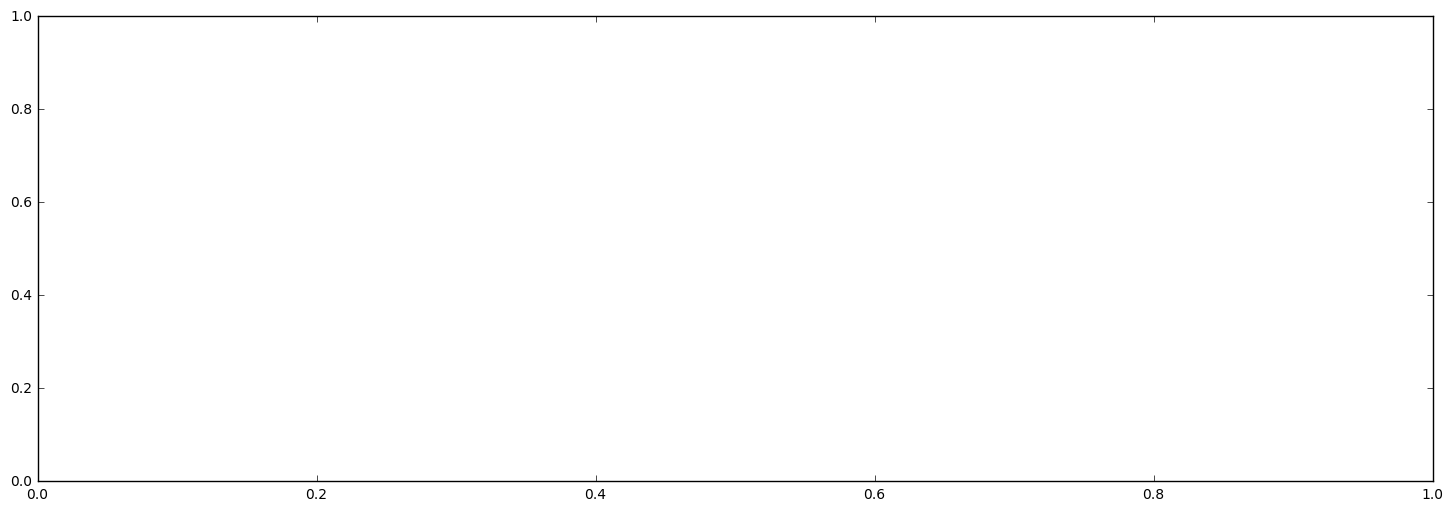

In [24]:
fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(111)

WEEK_TYPE = Week.FULL
# GROUPS_PER_HOUR must be >= 2
GROUPS_PER_HOUR = 6

working_hours = get_working_hours(Project.SKINIO, GROUPS_PER_HOUR)
time_labels = list(map(lambda label: (label if label <= 12 else label - 12), range(24)))

# matshow displays matrices in their native ratio. To get this to display well, the data will
# be padded. That will make each cell rectangular, but will make interpretation of the graph
# much easier.

target_ratio = 3
time_length = len(working_hours[Day.MON])
days_length = len(WEEK_TYPE.days())
current_ratio = time_length/days_length
padding_scaler = round(current_ratio/target_ratio)

df = []
for day in WEEK_TYPE.days():
    for _ in range(padding_scaler if padding_scaler > 0 else 1):
        df.append(working_hours[day])
        
ticker_locations = [round(padding_scaler / 2) - 1]
while (ticker_locations[-1] + padding_scaler) < len(df):
    ticker_locations.append(ticker_locations[-1] + padding_scaler)

cax = ax.matshow(df, interpolation='nearest', cmap='Blues')
fig.colorbar(cax)

ax.xaxis.set_major_locator(ticker.MultipleLocator(GROUPS_PER_HOUR))
ax.yaxis.set_major_locator(ticker.FixedLocator(ticker_locations))

ax.set_xticklabels([''] + list(time_labels))
ax.set_yticklabels(list(WEEK_TYPE.day_names()))

plt.show()